In [11]:
from utils.setup import load_model, load_data
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from torchsummary import summary

netG = load_model('netG', 'configs/config_StyleGan4x4.yaml')
netD = load_model('netD', 'configs/config_StyleGan4x4.yaml')


summary(netG, [512], depth=2);

Layer (type:depth-idx)                   Output Shape              Param #
├─ID_Layer: 1-1                          [-1, 512]                 --
|    └─MappingNetwork: 2-1               [-1, 512]                 2,101,248
├─ID_Layer: 1-2                          [-1, 512, 4, 4]           --
|    └─StyleGanInitBlock: 2-2            [-1, 512, 4, 4]           3,419,648
├─ModuleList: 1                          []                        --
|    └─ID_Layer: 2-3                     [-1, 3, 4, 4]             1,539
Total params: 5,522,435
Trainable params: 5,522,435
Non-trainable params: 0
Total mult-adds (M): 51.91
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 21.07
Estimated Total Size (MB): 21.26


In [13]:
data_train = load_data('train', 'configs/config_StyleGan4x4.yaml')
data_val = load_data('val', 'configs/config_StyleGan4x4.yaml')
data_test = load_data('test', 'configs/config_StyleGan4x4.yaml')


In [14]:
len(data_train.dataset), len(data_val.dataset), len(data_test.dataset)

(1020, 1020, 6149)

In [15]:
import torch
from torch.utils.data import random_split
from metrics.utils import activation_statistics, frechet_distance
num_samples = 1000
device = 'cuda:1'
netD.to(device)
# Split the dataset into a random subset and a complementary subset
train_subset, _ = random_split(data_train.dataset, [num_samples, len(data_train.dataset) - num_samples])
val_subset, _ = random_split(data_val.dataset, [num_samples, len(data_val.dataset) - num_samples])
train_images = [train_subset[i][0] for i in range(num_samples)]
val_images = [val_subset[i][0] for i in range(num_samples)]

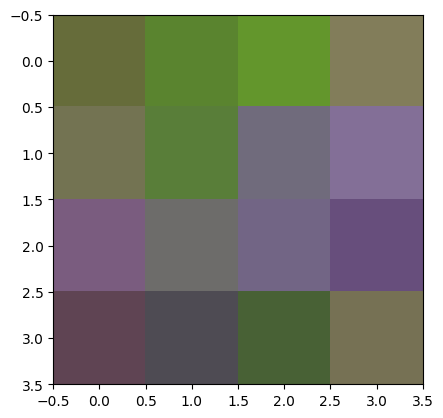

In [16]:
import matplotlib.pyplot as plt

def normalize(x):
    # return (x - x.min()) / (x.max() - x.min())
    return (x * 0.5) + 0.5

plt.imshow(normalize(train_images[-1]).permute(1, 2, 0))

In [29]:
from metrics.utils import cosine_similarity
import numpy as np
def compute_mean_and_variance(images):
    # Concatenate the images into a single NumPy array
    image_array = np.stack(images, axis=0)
    # Compute the mean and variance along the appropriate axes
    mean = np.mean(image_array, axis=(0))
    variance = np.var(image_array, axis=(0))

    return mean, variance

def mean_var_cosine_similarity(imgs1, imgs2):
    mean1, var1 = compute_mean_and_variance(imgs1)
    mean2, var2 = compute_mean_and_variance(imgs2)
    print(mean1.shape, var1.shape)
    print(mean2.shape, var2.shape)
    print(mean1.min(), mean1.max())
    print(mean2.min(), mean2.max())

    mean_cos = cosine_similarity(mean1.reshape(-1), mean2.reshape(-1))
    var_cos = cosine_similarity(var1.reshape(-1), var2.reshape(-1))

    return mean_cos, var_cos

def denormalize(normalized_data, mean, std):
    # Denormalize the data by multiplying by the standard deviation and adding the mean
    data = normalized_data * std + mean

    return data



In [31]:
mean_var_cosine_similarity(train_images[:3], val_images[:3])

(3, 4, 4) (3, 4, 4)
(3, 4, 4) (3, 4, 4)
-0.55294114 0.56078434
-0.7908497 0.30457518


(0.33519357442855835, 0.718048095703125)

In [19]:
mean_train, variance_train = compute_mean_and_variance(train_images)
print(mean_train.shape, variance_train.shape)
print(mean_train.min(), mean_train.max())
print(variance_train.min(), variance_train.max())

print("===============")

mean_val , variance_val = compute_mean_and_variance(val_images)
print(mean_val.shape, variance_val.shape)
print(mean_val.min(), mean_val.max())
print(variance_val.min(), variance_val.max())


(3, 4, 4) (3, 4, 4)
-0.56164116 0.22038417
0.07346227 0.18106861
(1000, 3, 4, 4)
(3, 4, 4) (3, 4, 4)
-0.5590059 0.22848608
0.06726346 0.18840206


In [20]:
print(mean_train.shape)

print(mean_train.reshape(-1).shape)

(3, 4, 4)
(48,)


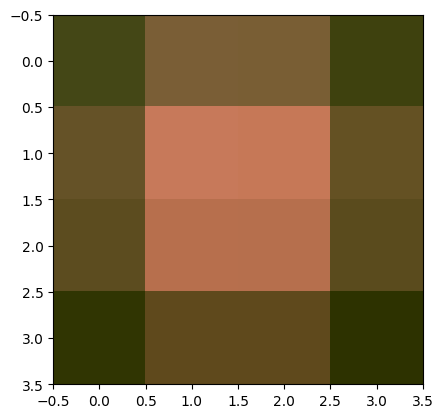

In [21]:
def min_shift(image):
    return image - image.min()

plt.imshow(min_shift(mean_train).transpose(1, 2, 0))

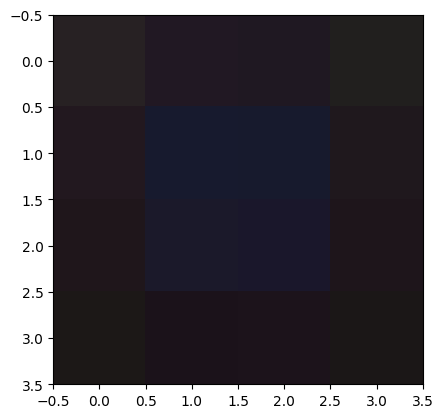

In [22]:
plt.imshow(variance_train.transpose(1, 2, 0))  

(1000, 3, 4, 4)
(3, 4, 4)
-0.56164116 0.22038417


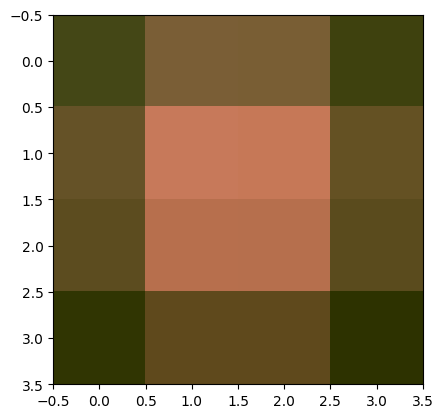

In [23]:
image_array = np.stack(train_images, axis=0)
print(image_array.shape)
sum_image = np.sum(image_array, axis=(0))
print(sum_image.shape)
sum_image = sum_image / len(train_images)
print(sum_image.min(), sum_image.max())

plt.imshow(min_shift(sum_image).transpose(1, 2, 0))

In [24]:
mean_train, std_train = activation_statistics(train_images, netD, device)
mean_val, std_val = activation_statistics(val_images, netD, device)
print(mean_val.shape, std_val.shape)

(512,) (512, 512)


In [25]:
fd = frechet_distance(mean_train, std_train, mean_val, std_val)
fd

p:\cgip_gan_2023\metrics\utils.py:33: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "frechet_distance" failed type inference due to: Unknown attribute 'sqrtm' of type Module(<module 'scipy.linalg' from 'p:\\cgip_gan_2023\\.venv\\lib\\site-packages\\scipy\\linalg\\__init__.py'>)

File "metrics\utils.py", line 67:
def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    <source elided>
    # Product might be almost singular
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)[0]
    ^

During: typing of get attribute at p:\cgip_gan_2023\metrics\utils.py (67)

File "metrics\utils.py", line 67:
def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    <source elided>
    # Product might be almost singular
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)[0]
    ^

  @nb.jit(nopython=False, cache=True, forceobj=False)
p:\cgip_gan_2023\.venv\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaW

1.552357160398273